In [6]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.timeseries import LombScargle
from scipy.signal import savgol_filter
from astropy.convolution import convolve, Box1DKernel
from scipy.stats import binned_statistic
import scipy.stats as st
import astropy.units as u
import pandas as pd
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [7]:
# base = 'AS1G05_230T02_9000000548uvtFIIPC00F1_l2ce'
# directory = ['/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_01/F_01/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_02/F_02/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_03/F_03/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_04/F_04/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_05/F_05/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_06/F_06/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_07/F_07/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_08/F_08/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_09/F_09/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_11/F_11/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_13/F_13/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_15/F_15/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_17/F_17/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_19/F_19/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_20/F_20/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_21/F_21/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_22/F_22/', \
#             '/home/ravioli/astro/ksp/uvit/20160720_G05_230T02_9000000548_level2/uvit/RAS_VIS/uvt_23/F_23/']

# MJD = []
# counts = []
# counts_err = []
# source = pd.DataFrame(pd.read_csv('sources_new.csv'))
# for i in range(len(directory)):
#     data = pd.read_csv(directory[i]+'makecurves_'+str(source['xp'][i])+'_'+str(source['yp'][i])+'_'+base+'.dat', delimiter='	')
#     lc = pd.DataFrame(data)
#     MJD.append(lc.iloc[:, 0].values)
#     counts.append(lc.iloc[:, 1].values)
#     counts_err.append(lc.iloc[:, 2].values)
# MJD = np.concatenate(MJD)
# counts = np.concatenate(counts)
# counts_err = np.concatenate(counts_err)
# #np.savetxt('lc.txt', np.c_[MJD, counts, counts_err], delimiter=',', header='MJD, counts, counts_err')
# #MJD = 2444884.2176 + MJD*0.07891518

In [8]:
df = pd.DataFrame(pd.read_csv('lc.txt', delimiter=','))
sort = np.argsort(df['MJD'].values)
MJD = df['MJD'].values[sort]
counts = df[' counts'].values[sort]
counts_err = df[' counts_err'].values[sort]

Mean count rate:  1.1176594421364987  +/-  0.27606515806920445


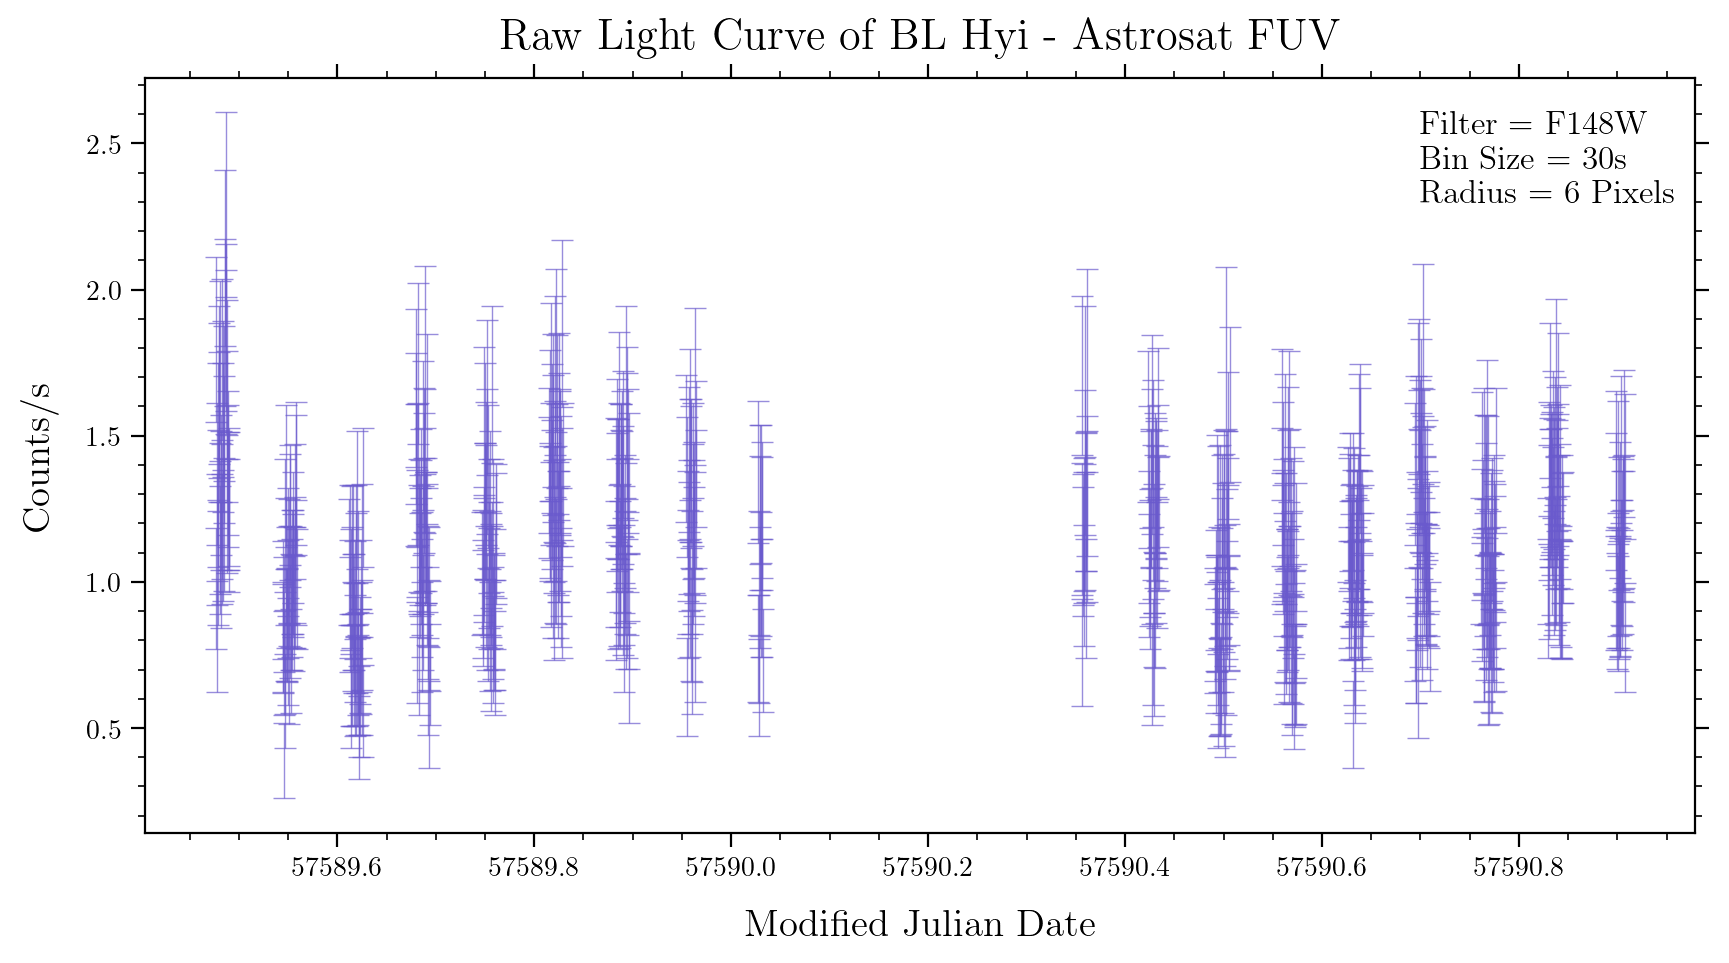

In [9]:
plt.figure(figsize=(10, 5), dpi=200)
plt.errorbar(MJD, counts, yerr=counts_err, fmt='o', color='slateblue', ms=0, elinewidth=0.5, capsize=4, capthick=0.5, alpha=0.69)
plt.xlabel('Modified Julian Date', fontsize=14, labelpad=10)
plt.ylabel('Counts/s', fontsize=14, labelpad=10)
print("Mean count rate: ", np.mean(counts), " +/- ", np.std(counts))
plt.title('Raw Light Curve of BL Hyi - Astrosat FUV', fontsize=16, pad=10)
plt.text(57590.7, 2.3, f' Filter = F148W \n Bin Size = 30s \n Radius = 6 Pixels', fontsize=12)
plt.show()

$\text{HJD}  = 2444884.2176(6) + 0.07891518(4)\times \text{E}$

In [10]:
#correct for ephimeris
i = 0
JD = MJD + 2400000.5
while True:
    if (2444901.9744+0.07891507*i)/JD[0] >=1:
        print(i-1)
        break
    i += 1
print(JD[0])

160780
2457589.976758099


Best period: 1.8974131096710156 hours


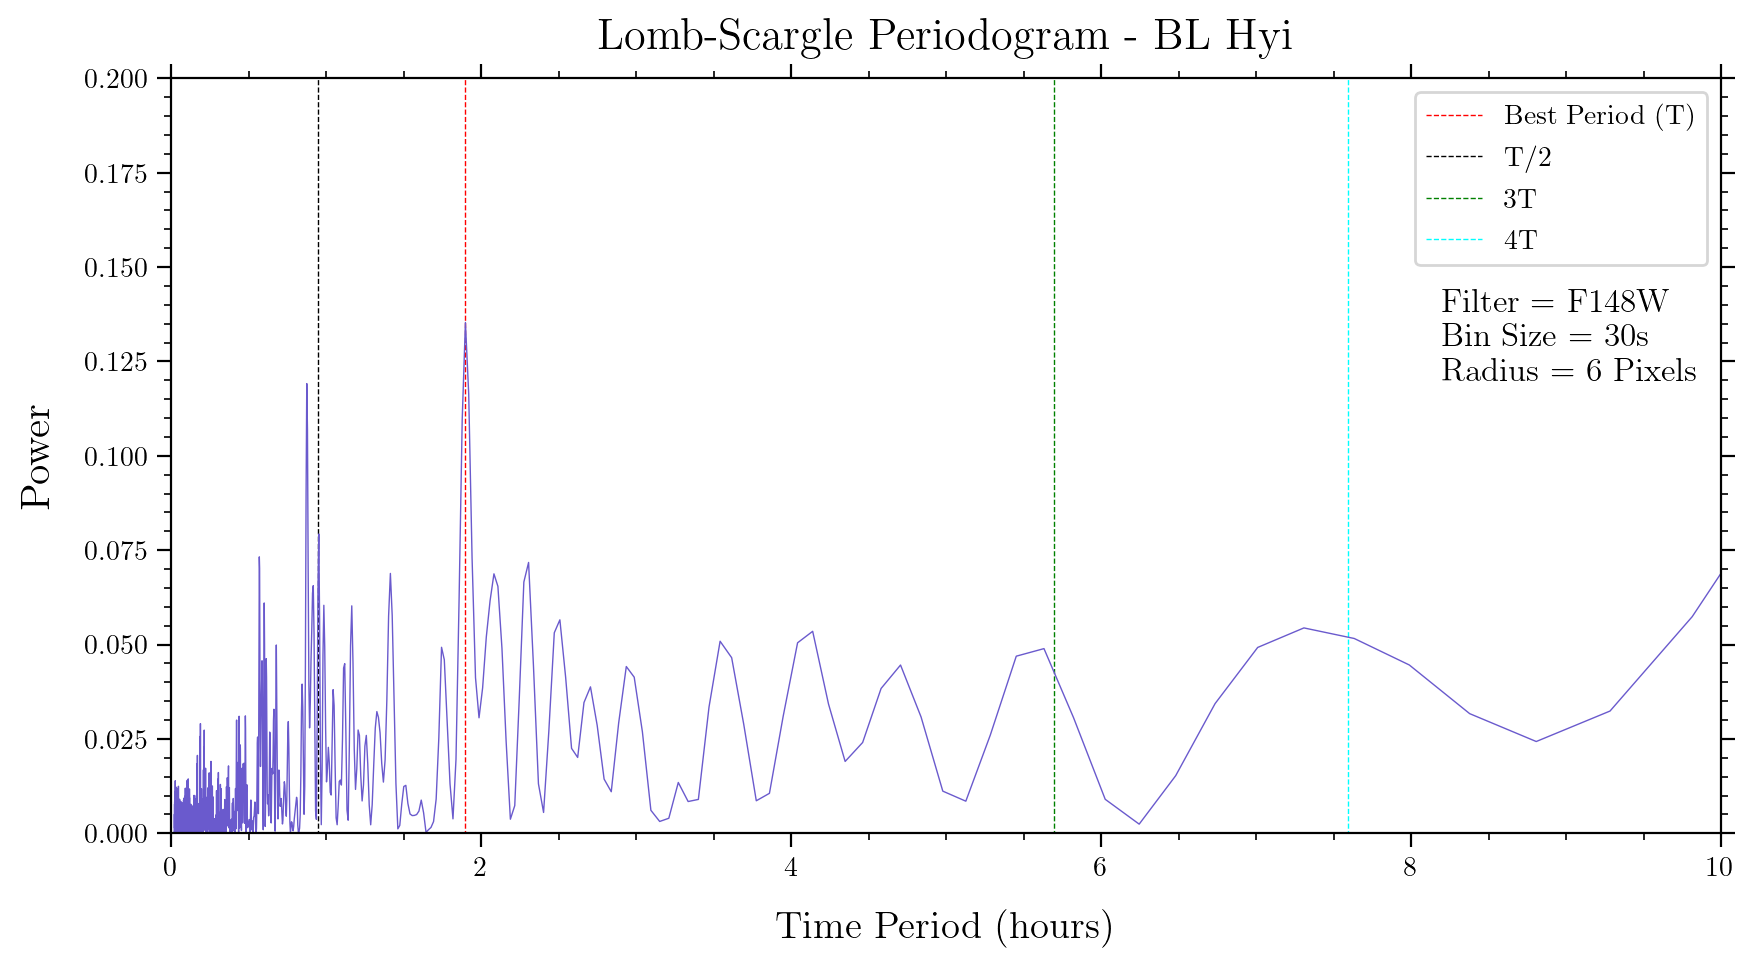

In [11]:
JD = JD - (2444884.2176+0.07891518*160780)
#convert to hours
JD_hour = JD*24
frequency, power = LombScargle(JD_hour, counts).autopower()
best_frequency = frequency[np.argmax(power)]
best_period = 1/best_frequency
print('Best period:', best_period, "hours")
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(1/frequency, power, color='slateblue', lw=0.5)
plt.vlines(best_period, -0.1, 1, color='red', lw=0.5, linestyle='--', label='Best Period (T)')
plt.vlines(0.5*best_period, -0.1, 1, color='black', lw=0.5, linestyle='--', label='T/2')
plt.vlines(3*best_period, -0.1, 1, color='green', lw=0.5, linestyle='--', label='3T')
plt.vlines(4*best_period, -0.1, 1, color='cyan', lw=0.5, linestyle='--', label='4T')
plt.xlabel('Time Period (hours)', fontsize=14, labelpad=10)
plt.ylabel('Power', fontsize=15, labelpad=10)
plt.title('Lomb-Scargle Periodogram - BL Hyi', fontsize=16, pad=10)
plt.legend()
plt.text(8.2, 0.12, f' Filter = F148W \n Bin Size = 30s \n Radius = 6 Pixels', fontsize=12)
plt.xlim(0,10)
plt.ylim(0,0.2)
plt.show()

Text(0.5, 1.0, 'Phase-Folded Light Curve - BL Hyi')

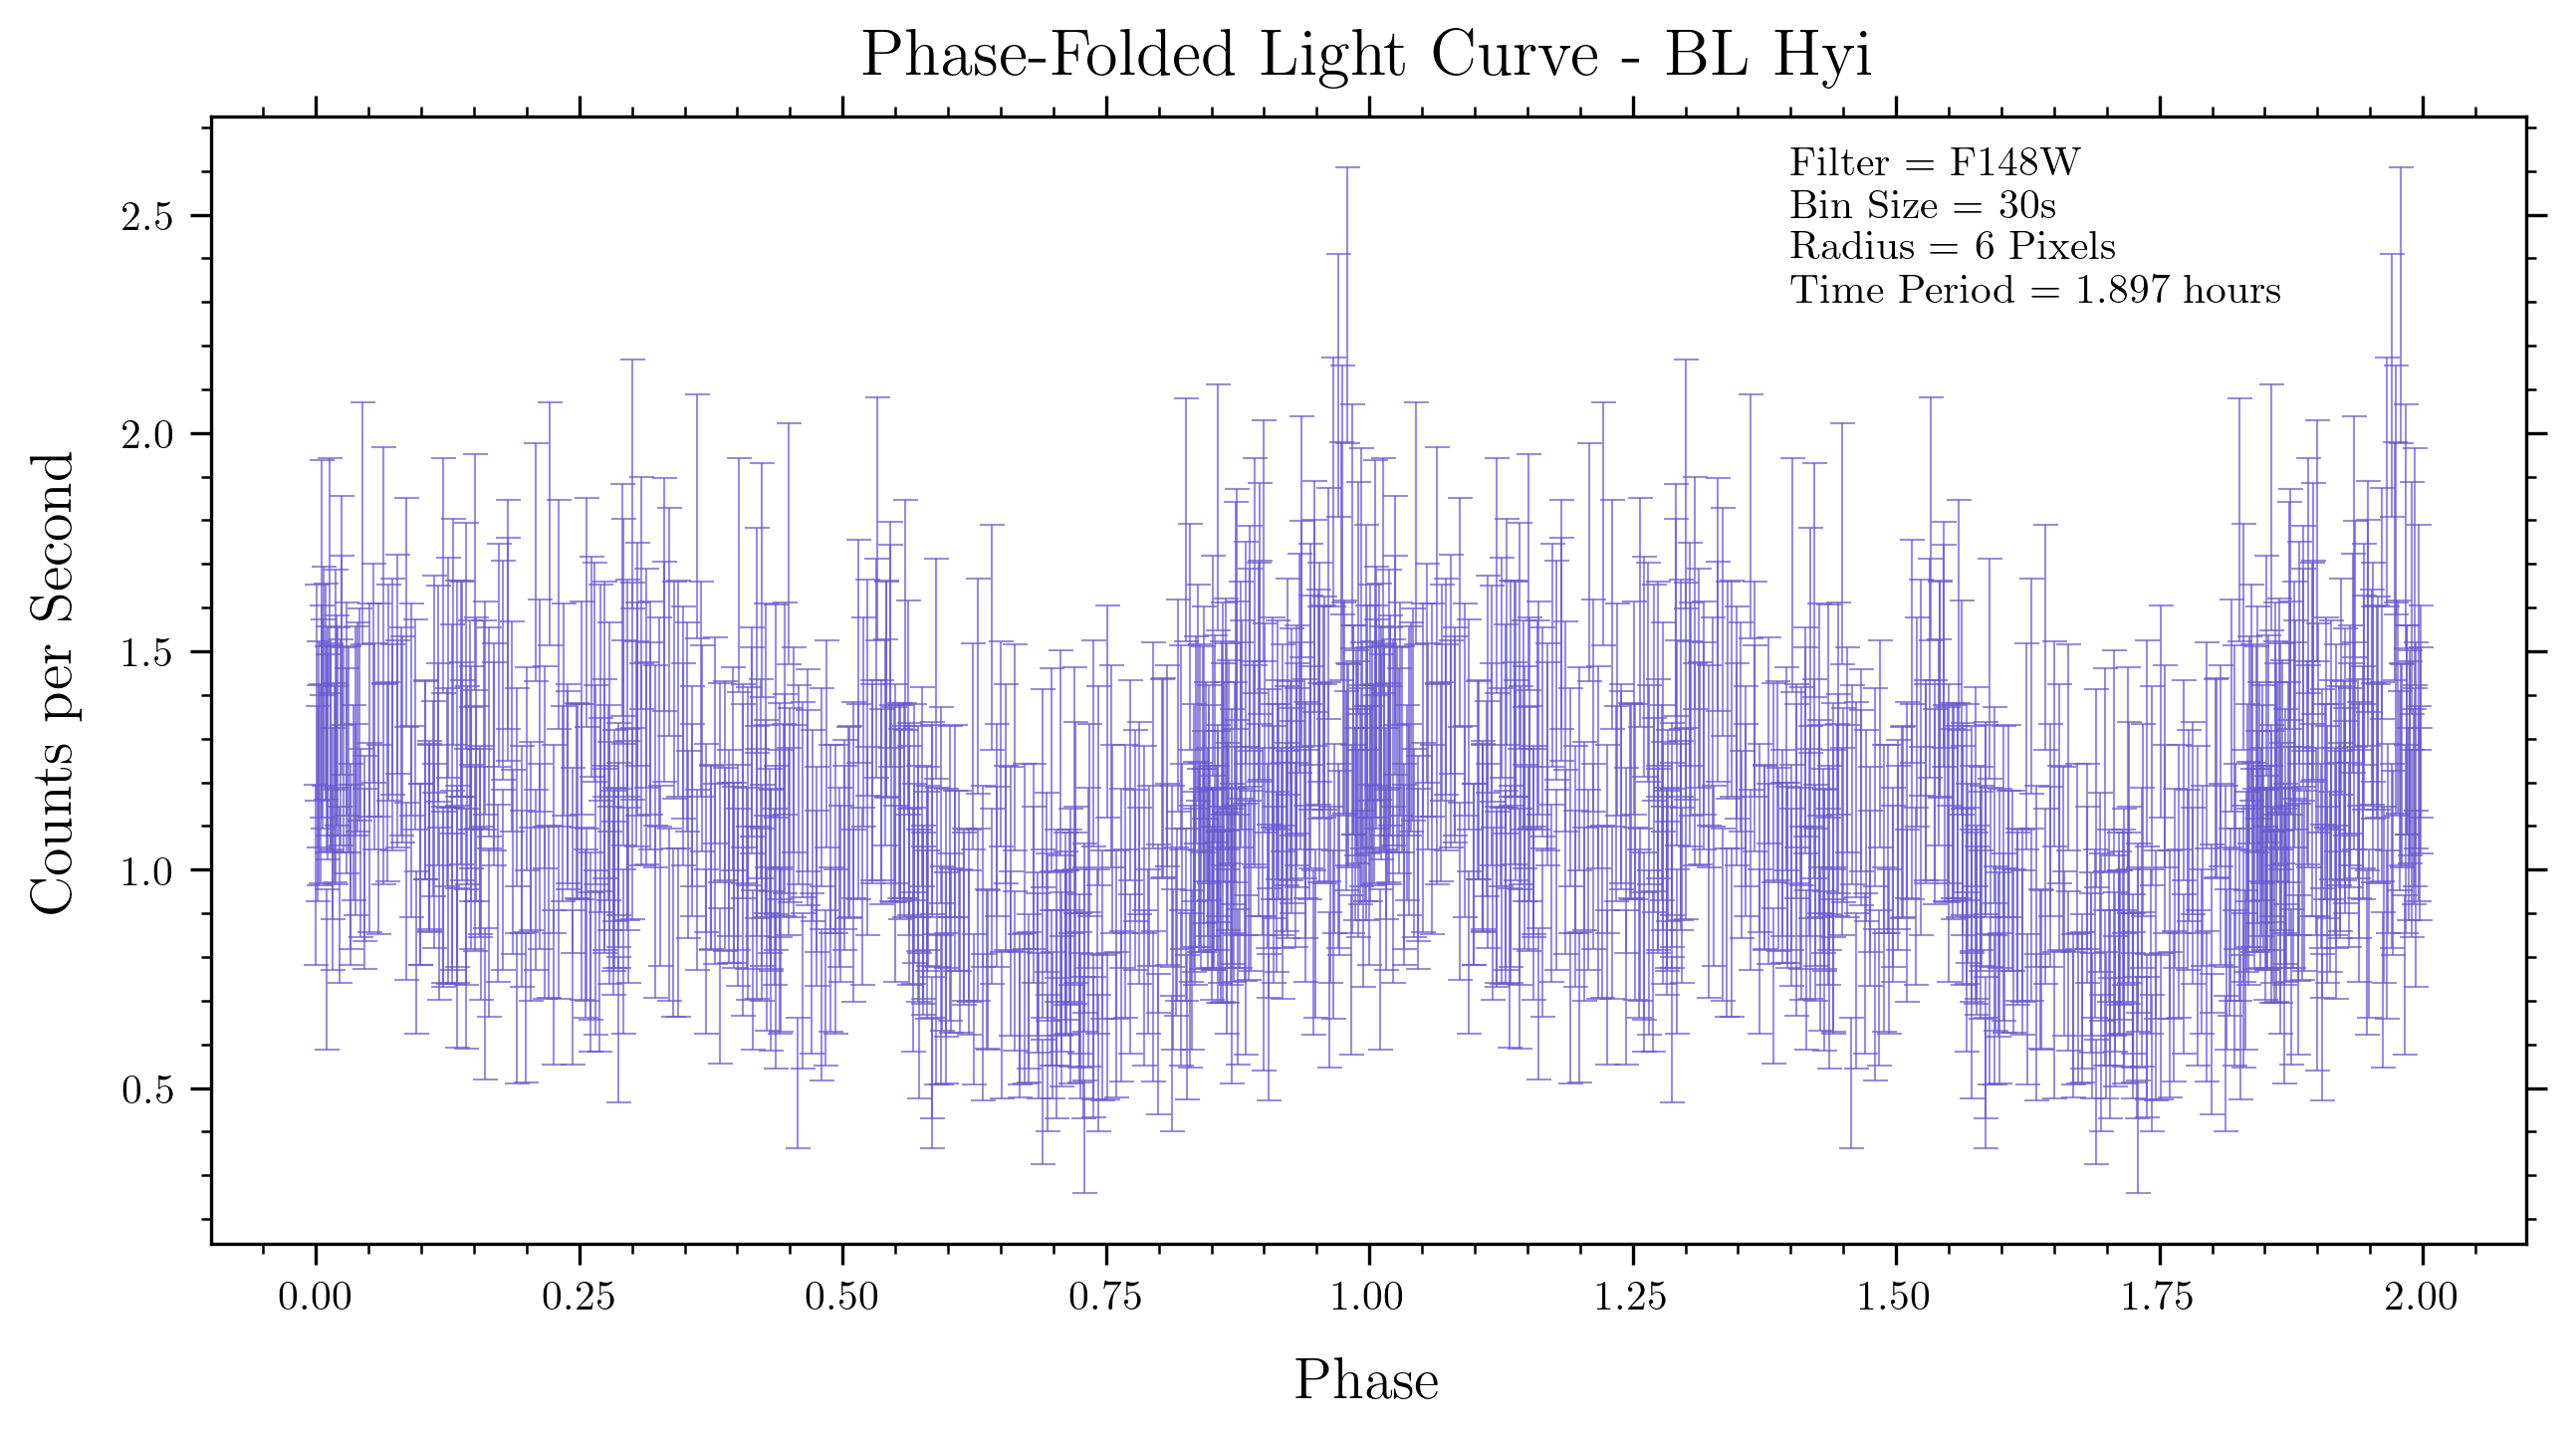

In [12]:
phase = (JD_hour)/best_period-np.floor((JD_hour)/best_period)
phase = np.concatenate((phase, phase+1))
counts = np.concatenate((counts, counts))
counts_err = np.concatenate((counts_err, counts_err))
plt.figure(figsize=(10, 5), dpi=300)
plt.errorbar(phase, counts, yerr=counts_err, fmt='o', color='slateblue', ms=0, elinewidth=0.5, capsize=3, capthick=0.5, alpha=0.69)
plt.text(1.4, 2.3, f' Filter = F148W \n Bin Size = 30s \n Radius = 6 Pixels \n Time Period = 1.897 hours', fontsize=10)
plt.xlabel('Phase', fontsize=14, labelpad=10)
plt.ylabel('Counts per Second', fontsize=14, labelpad=10)
plt.title('Phase-Folded Light Curve - BL Hyi', fontsize=16, pad=10)

In [13]:
sort_phase = np.argsort(phase)
sorted_phase = phase[sort_phase]
sorted_counts = counts[sort_phase]
sorted_counts_err = counts_err[sort_phase]
# print(len(sorted_counts))
# filtered_counts = savgol_filter(sorted_counts, 69, 5)
# filtered_error = savgol_filter(sorted_counts_err, 50, 5)
# plt.figure(figsize=(10, 5), dpi=300)
# plt.plot(sorted_phase, filtered_counts, color='mediumslateblue')
# plt.errorbar(sorted_phase, filtered_counts, sorted_counts_err, fmt='o', color='slateblue', ms=0, elinewidth=2, alpha=0.1, capsize=1, capthick=0.5)
# plt.xlabel('Phase', fontsize=14, labelpad=10)
# plt.ylabel('Counts', fontsize=14, labelpad=10)
# plt.title('Phase-folded light curve', fontsize=16, pad=10)
# plt.show()

In [14]:
# #astropy convolution
# box_kernel = Box1DKernel(100)
# smoothed_counts = convolve(sorted_counts, box_kernel)
# plt.figure(figsize=(10, 5), dpi=300)
# plt.plot(sorted_phase, smoothed_counts, color='mediumslateblue')
# plt.errorbar(sorted_phase, smoothed_counts, sorted_counts_err, fmt='o', color='slateblue', ms=0, elinewidth=2, alpha=0.1, capsize=1, capthick=0.5)
# plt.xlabel('Phase', fontsize=14, labelpad=10)
# plt.ylabel('Counts', fontsize=14, labelpad=10)
# plt.title('Phase-folded light curve', fontsize=16, pad=10)
# plt.show()

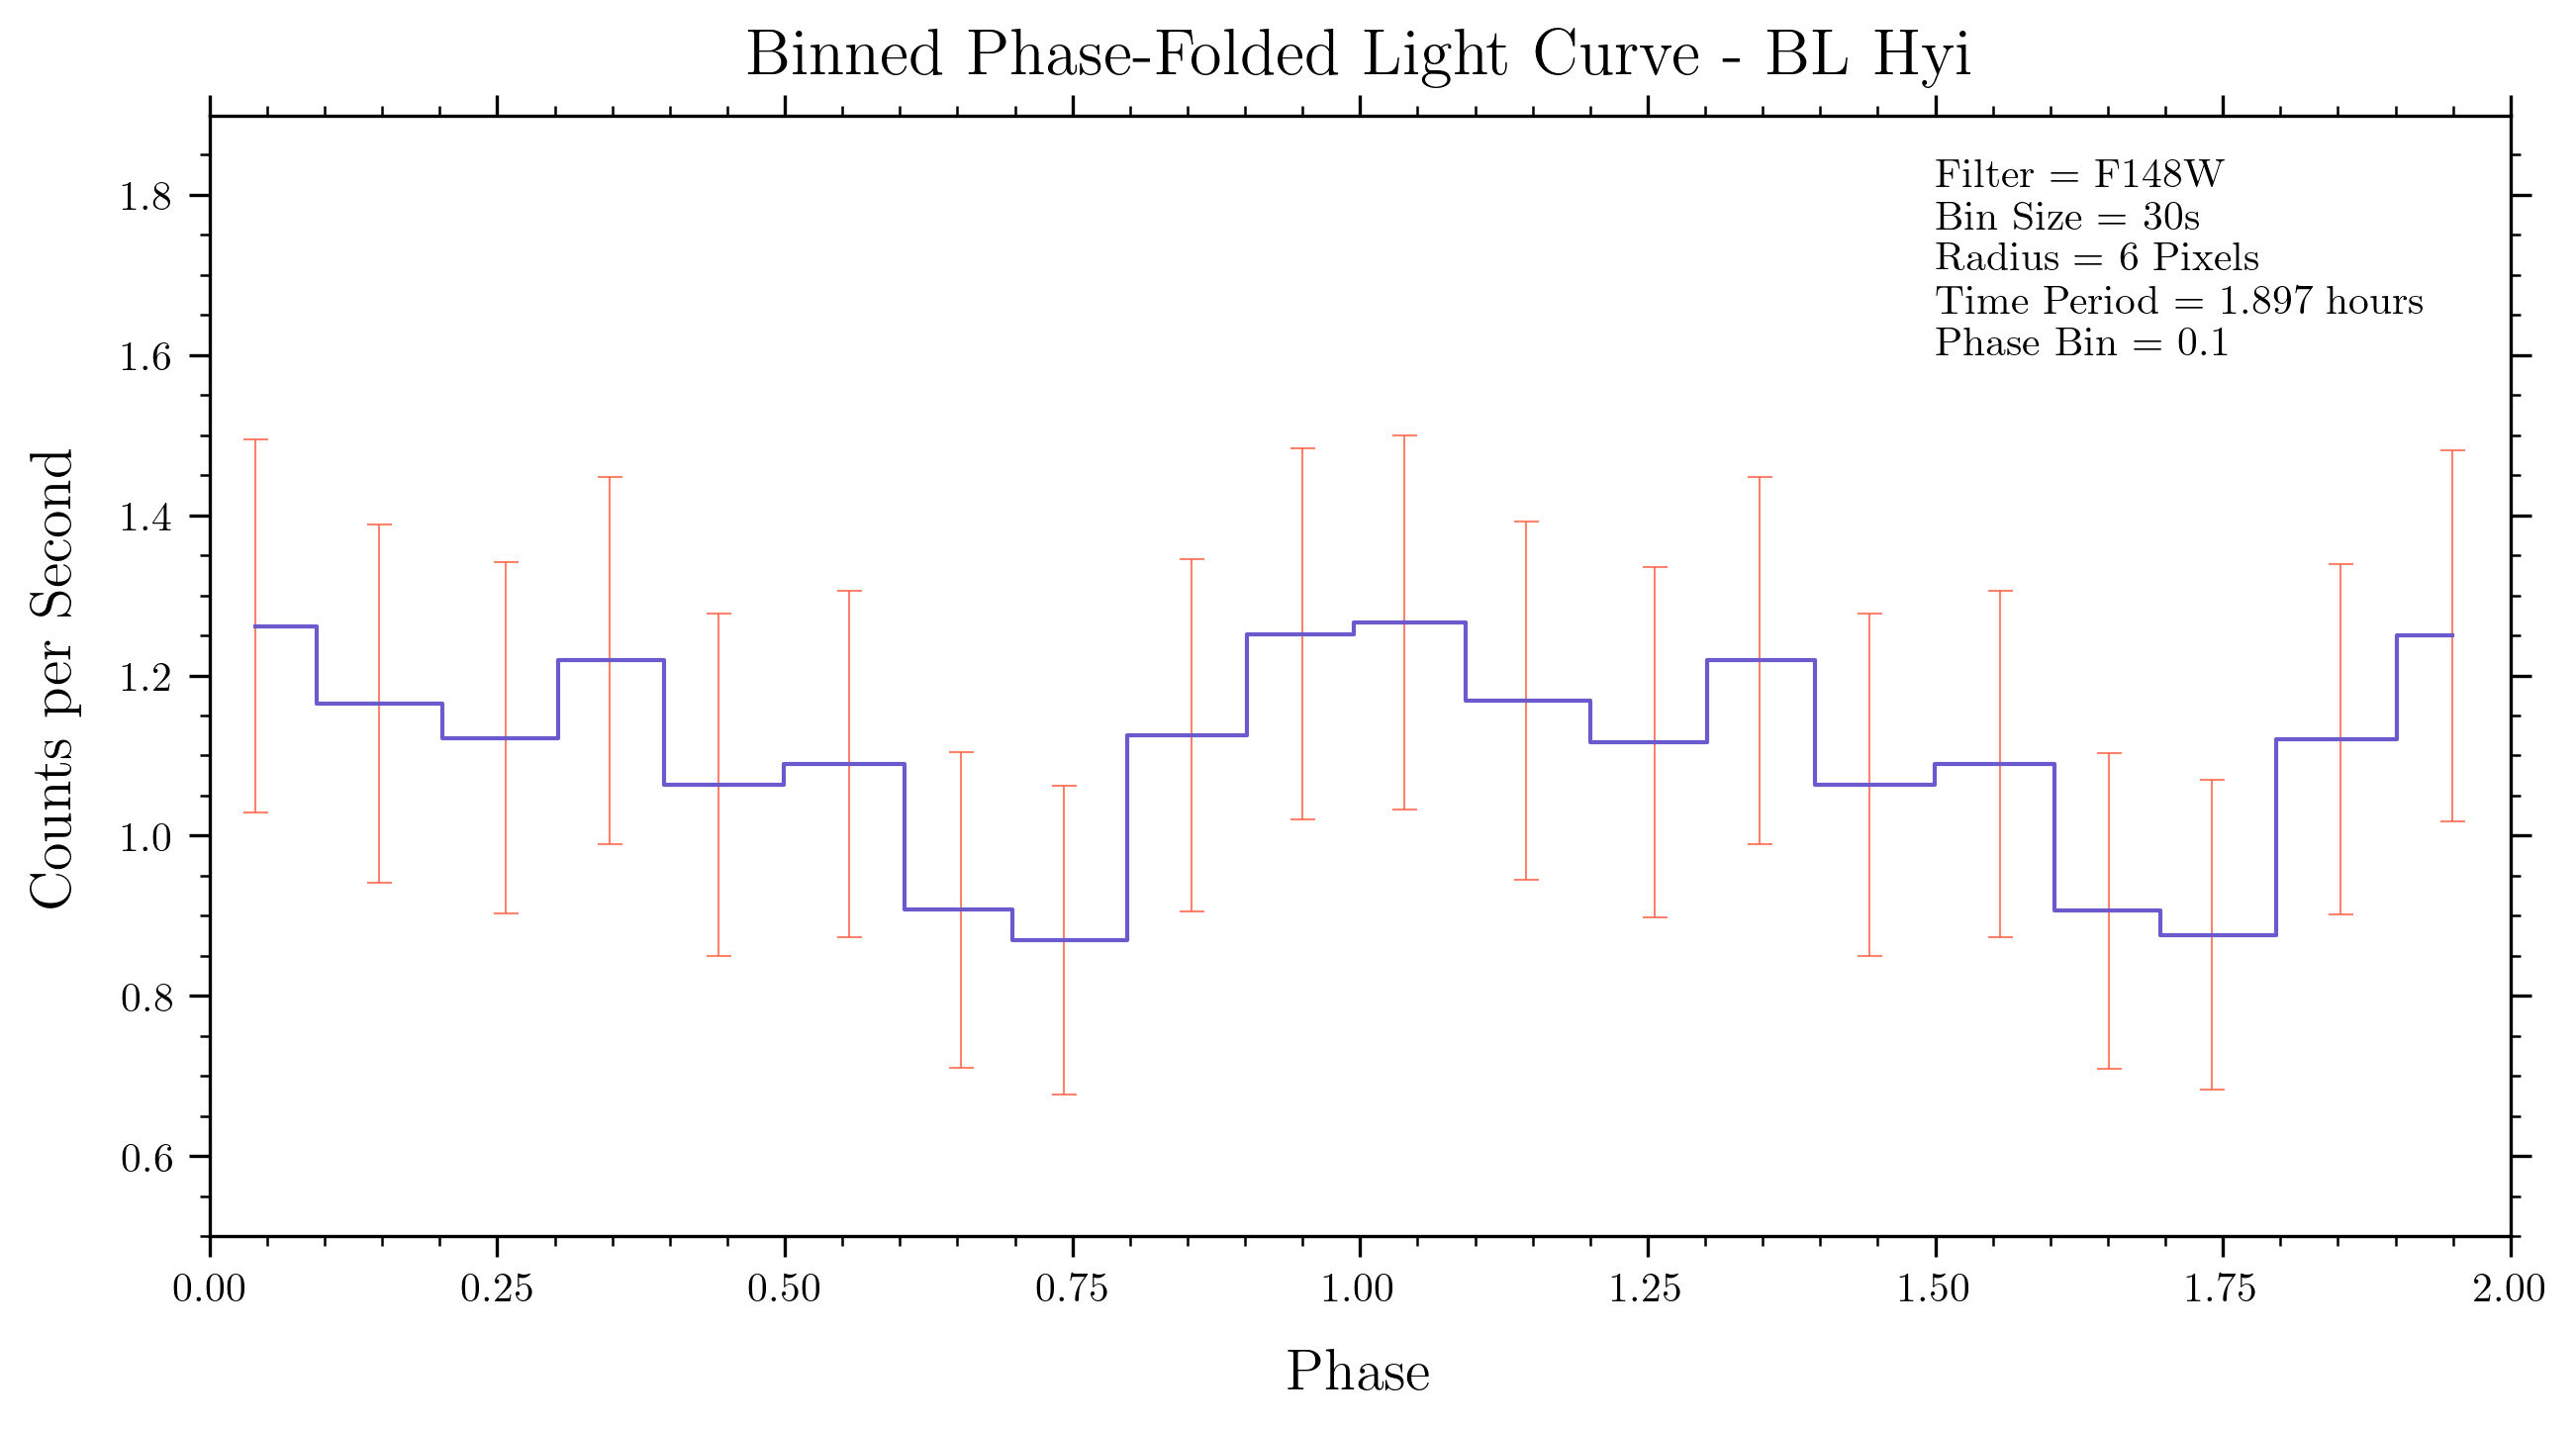

In [15]:
#downsample the data by averaging over 20 points
binned_phase = binned_statistic(sorted_phase, sorted_phase, bins=20, statistic='mean').statistic
binned_counts = binned_statistic(sorted_phase, sorted_counts, bins=20, statistic='mean').statistic
binned_error = binned_statistic(sorted_phase, sorted_counts_err, bins=20, statistic='mean').statistic
plt.figure(figsize=(10, 5), dpi=300)
plt.step(binned_phase, binned_counts, color='slateblue', where='mid', linewidth=1)
plt.errorbar(binned_phase, binned_counts, binned_error, fmt='o', color='tomato', ms=0, elinewidth=0.5, alpha=0.8, capsize=3, capthick=0.5)
plt.xlim(0, 2)
plt.ylim(0.5, 1.5*np.max(binned_counts))
plt.xlabel('Phase', fontsize=14, labelpad=10)
plt.ylabel('Counts per Second', fontsize=14, labelpad=10)
plt.title('Binned Phase-Folded Light Curve - BL Hyi', fontsize=16, pad=10)
plt.text(1.5, 1.6, f' Filter = F148W \n Bin Size = 30s \n Radius = 6 Pixels \n Time Period = 1.897 hours \n Phase Bin = 0.1', fontsize=10)
plt.show()

$\text{Flux } (\text{ergs } \text{cm}^{-2} \text{s}^{-1}$ $\AA^{-1}) =  \text{CPS} \times \text{Unit Conversion}$

$\text{m}_{\text{AB}} = -2.5\log{\text{CPS}}+\text{Zero Point}$

$\text{Unit Conversion for F148W} = 3.09\times 10^{-15}$

$\text{Zero Point for F148W} = 18.016$

$f = \lambda f_{\lambda}$

Mean Flux =  3.4222872621415857e-15


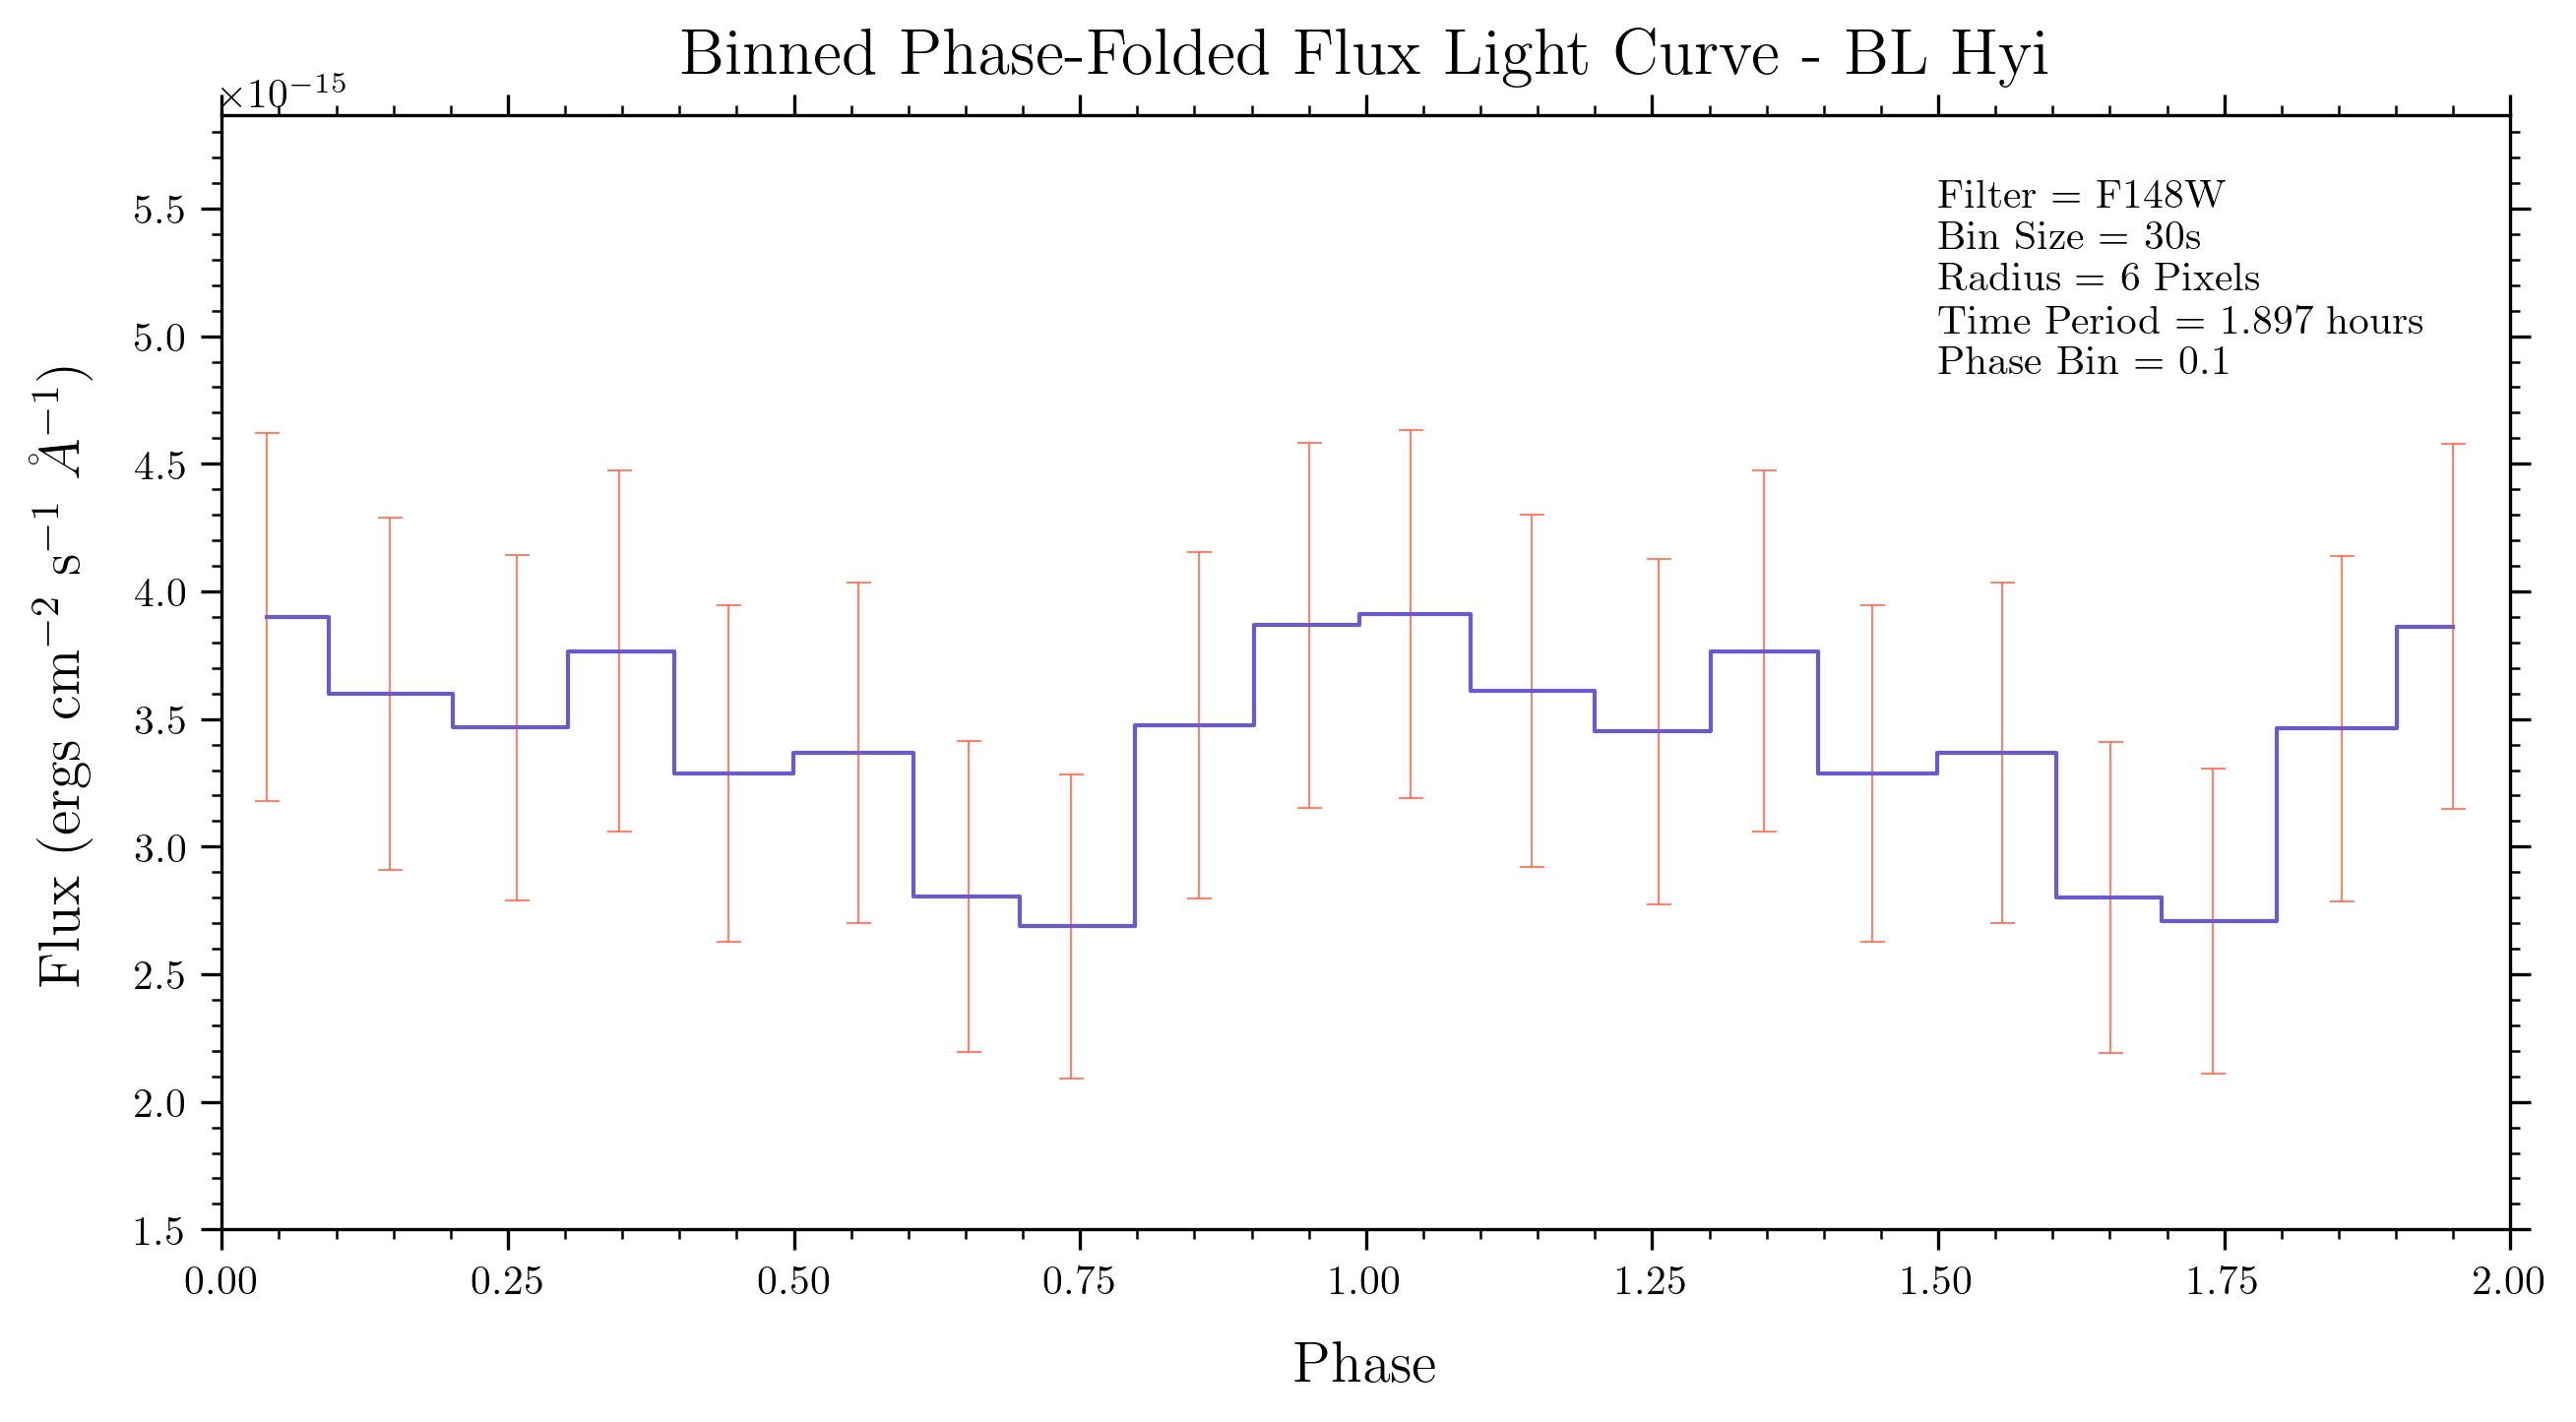

In [16]:
binned_flux = binned_counts*3.09e-15
binned_flux_err = binned_error*3.09e-15
binned_m_ab = -2.5*np.log10(binned_counts)+18.016
binned_m_ab_err = -2.5/np.log(10)*binned_flux_err/binned_flux
plt.figure(figsize=(10, 5), dpi=300)
plt.step(binned_phase, binned_flux, color='slateblue', linewidth=1, where='mid')
plt.errorbar(binned_phase, binned_flux, binned_flux_err, fmt='o', color='tomato', ms=0, elinewidth=0.5, alpha=0.8, capsize=3, capthick=0.5)
plt.xlabel('Phase', fontsize=14, labelpad=10)
plt.ylabel('Flux (ergs cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)', fontsize=14, labelpad=10)
plt.xlim(0, 2)
plt.ylim(1.5e-15, 1.5*np.max(binned_flux))
plt.title('Binned Phase-Folded Flux Light Curve - BL Hyi', fontsize=16, pad=10)
plt.text(1.5, 4.85e-15, f'Filter = F148W \n Bin Size = 30s \n Radius = 6 Pixels \n Time Period = 1.897 hours \n Phase Bin = 0.1', fontsize=10)
print("Mean Flux = ", np.mean(binned_flux))
plt.show()

Mean Luminosity =  3.4070369230193337e+30


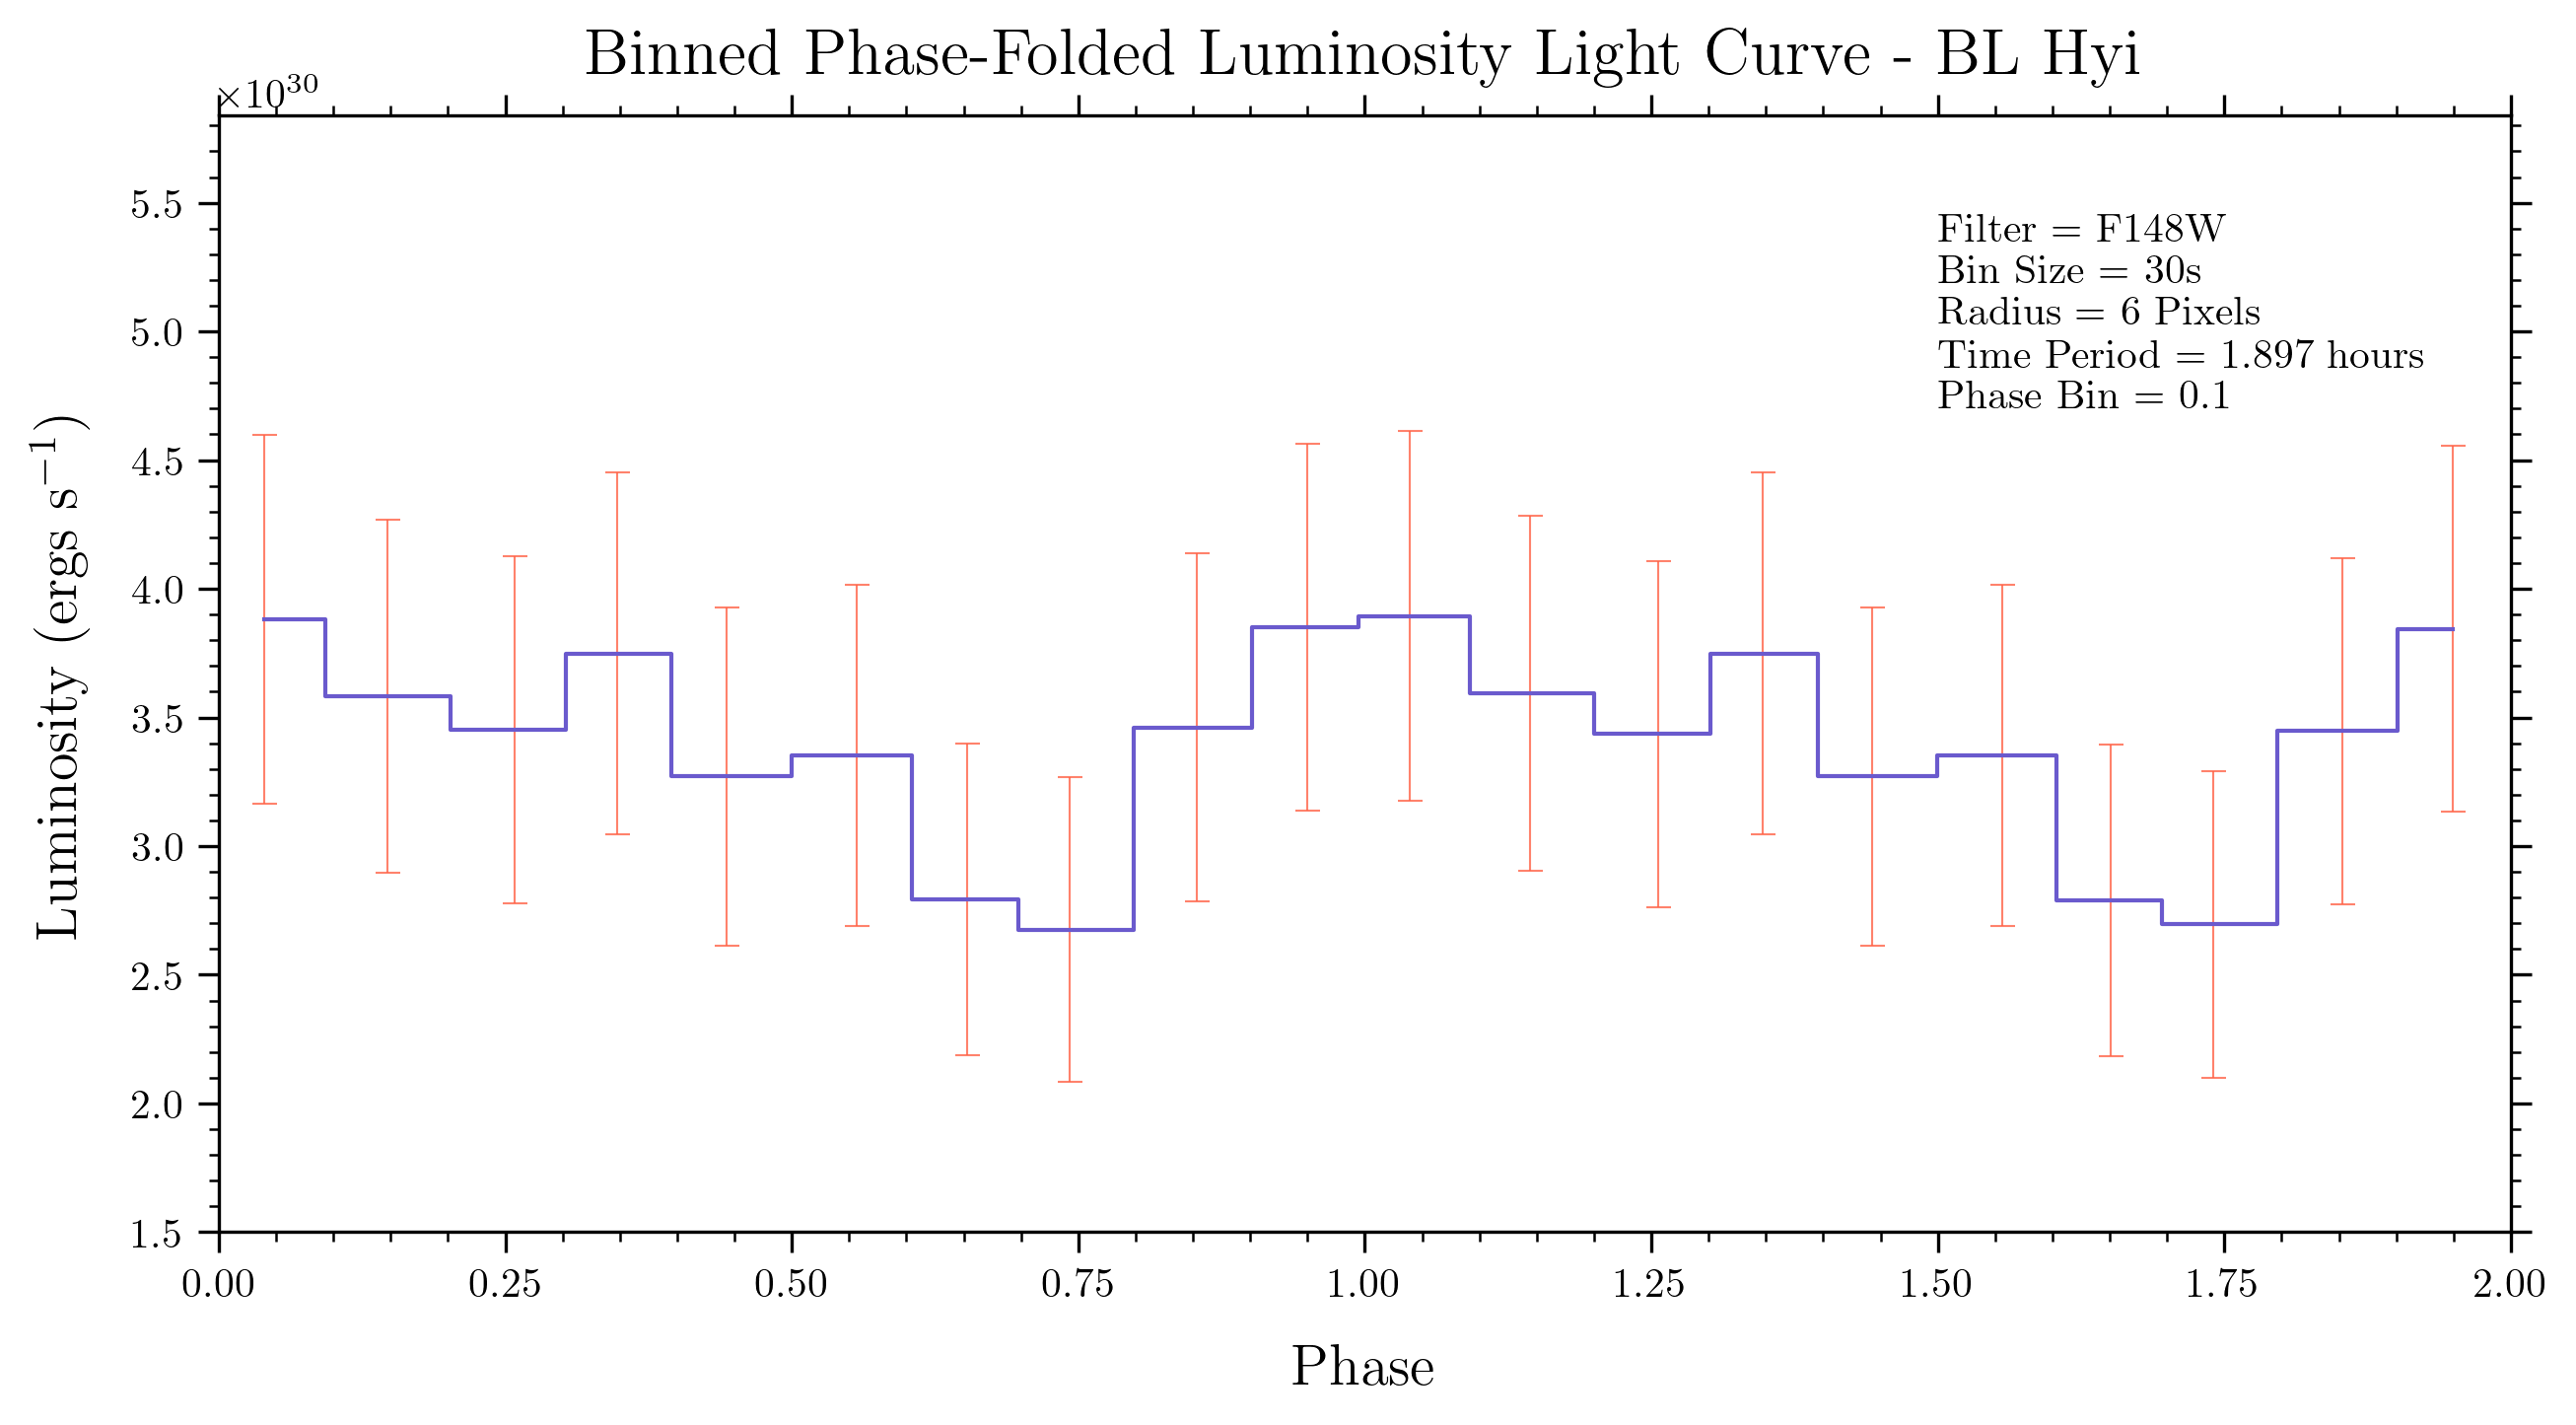

In [17]:
distance = 129*3.08567758128e+18 # in cm
binned_luminosity = binned_flux*4*np.pi*(distance**2)*500
binned_luminosity_err = binned_flux_err*4*np.pi*(distance**2)*500
plt.figure(figsize=(10, 5), dpi=300)
plt.step(binned_phase, binned_luminosity, color='slateblue', linewidth=1, where='mid')
plt.errorbar(binned_phase, binned_luminosity, binned_luminosity_err, fmt='o', color='tomato', ms=0, elinewidth=0.5, alpha=0.8, capsize=3, capthick=0.5)
plt.xlabel('Phase', fontsize=14, labelpad=10)
plt.ylabel('Luminosity (ergs s$^{-1}$)', fontsize=14, labelpad=10)
plt.xlim(0, 2)
plt.ylim(1.5e+30, 1.5*np.max(binned_luminosity))
plt.title('Binned Phase-Folded Luminosity Light Curve - BL Hyi', fontsize=16, pad=10)
plt.text(1.5, 4.7e+30, f'Filter = F148W \n Bin Size = 30s \n Radius = 6 Pixels \n Time Period = 1.897 hours \n Phase Bin = 0.1', fontsize=10)
print("Mean Luminosity = ", np.mean(binned_luminosity))
plt.show()

Mean Magnitude =  17.912578107214998


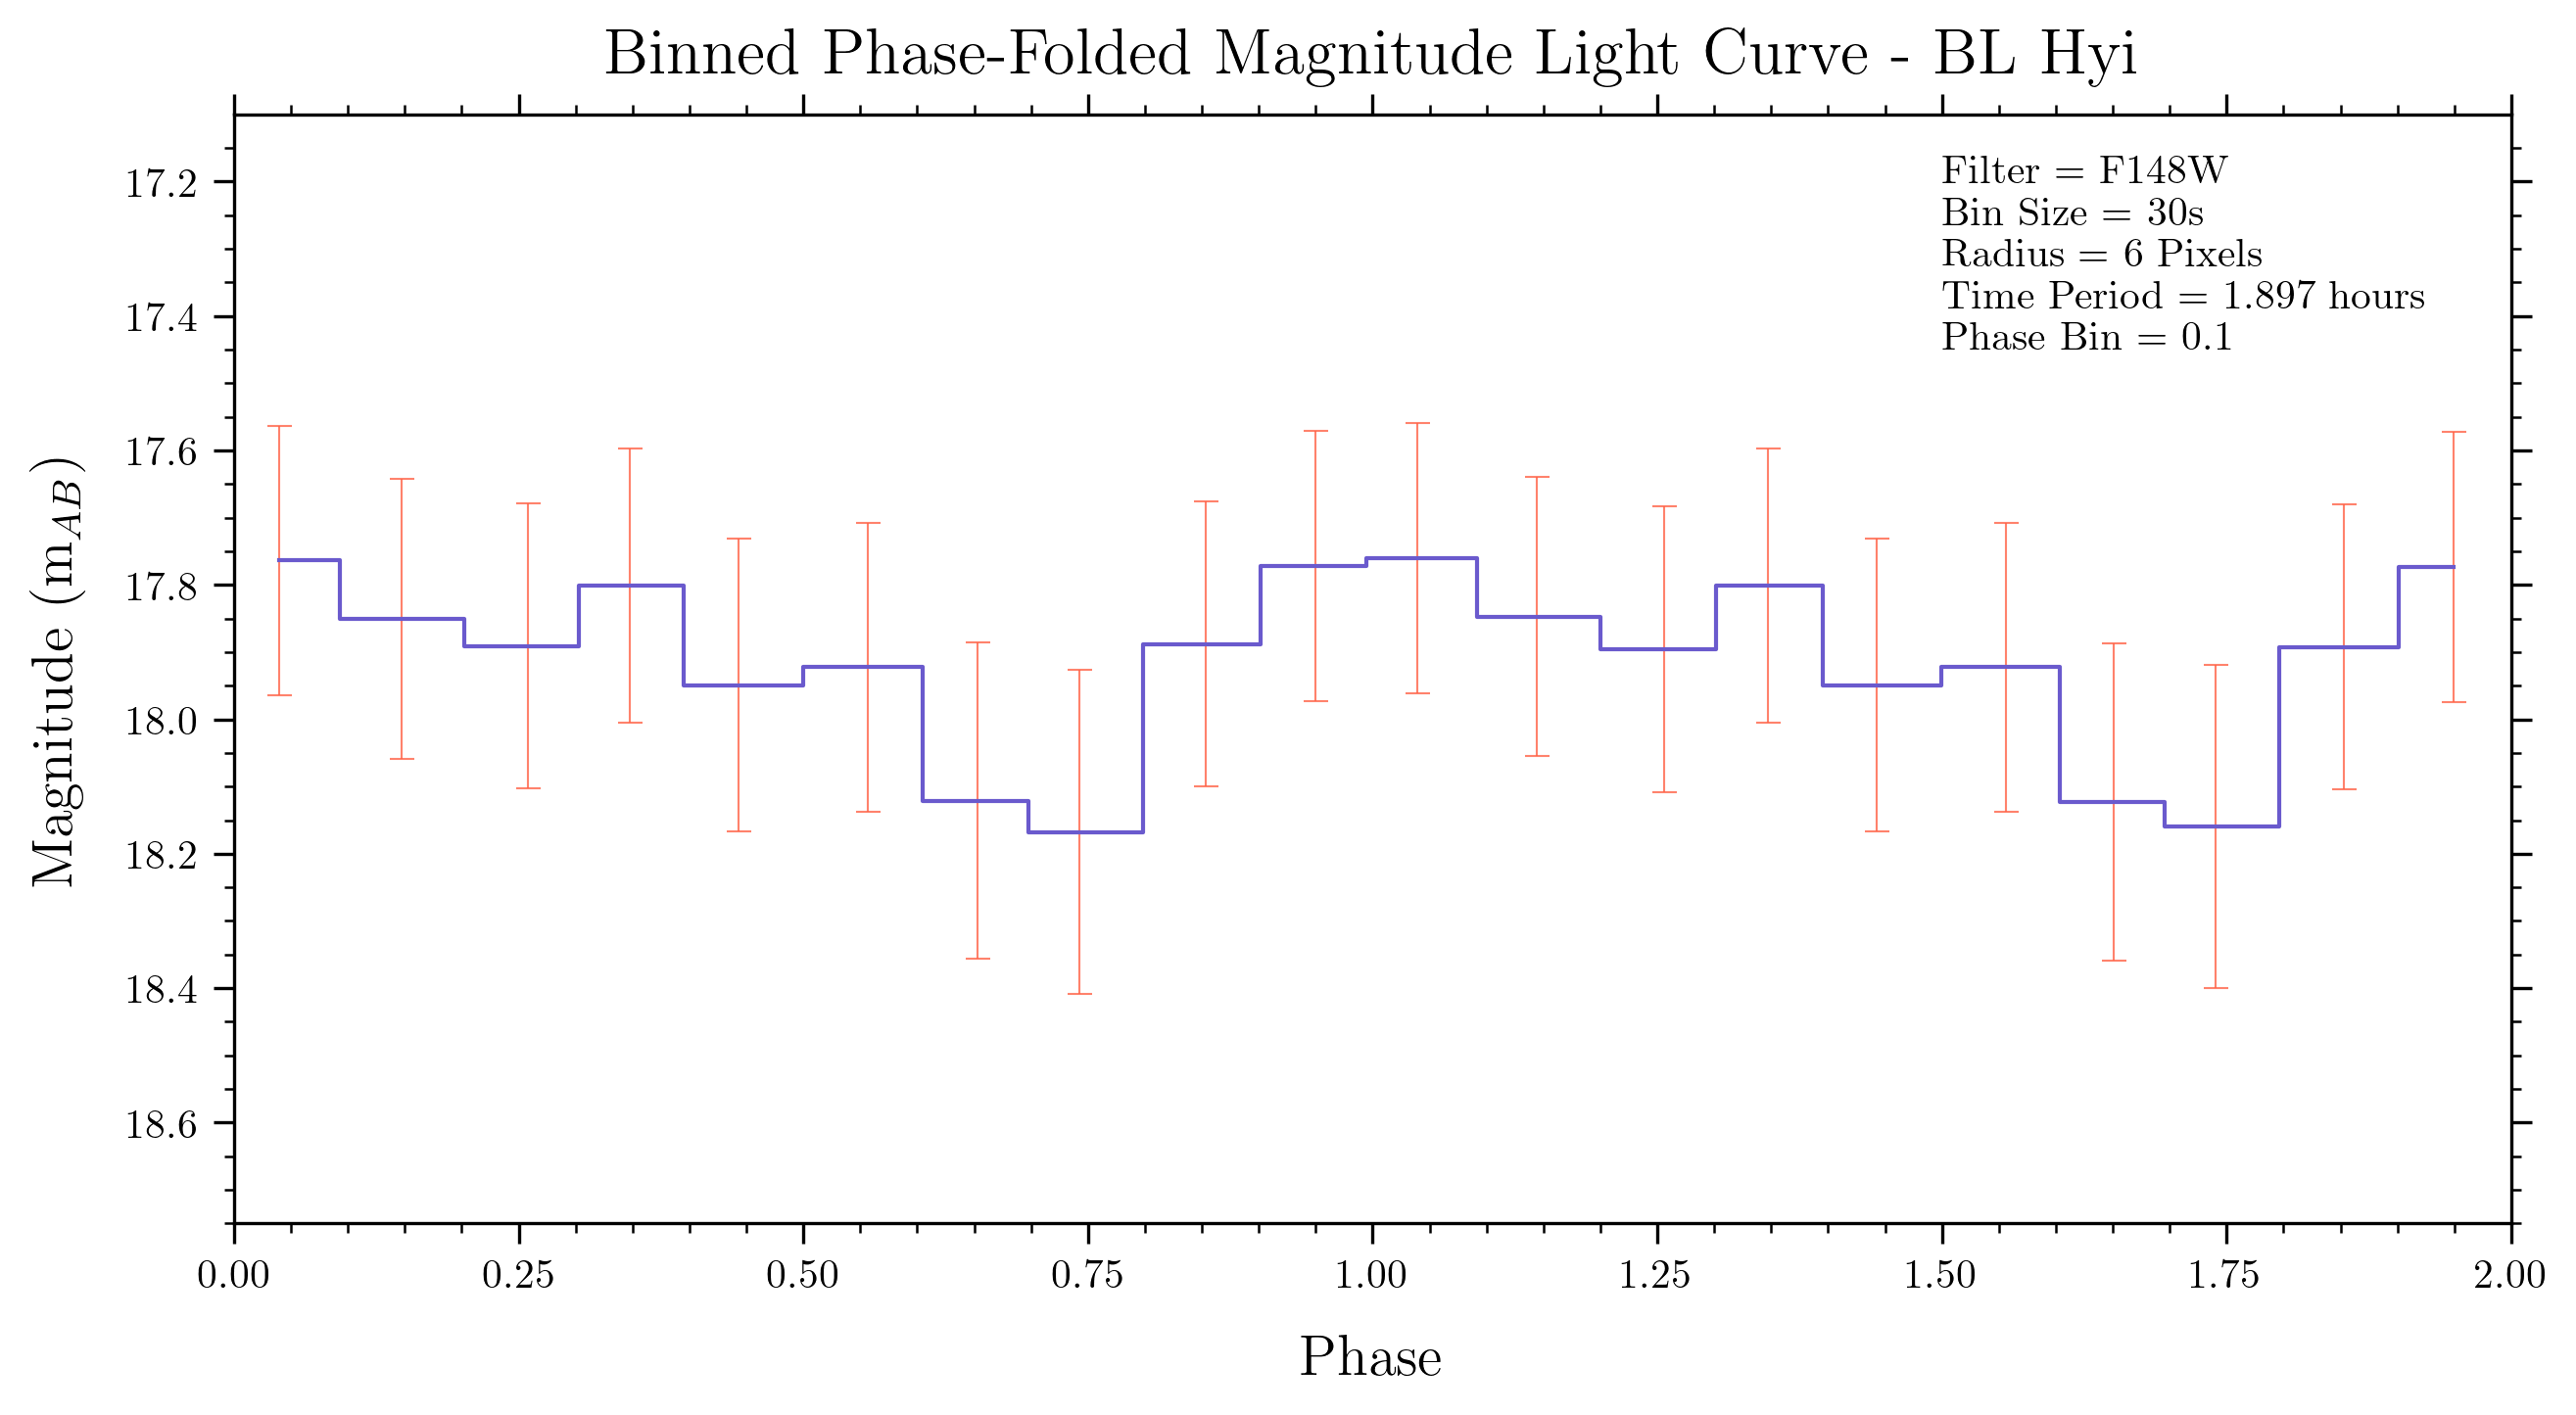

In [18]:
plt.figure(figsize=(10, 5), dpi=300)
plt.step(binned_phase, binned_m_ab, color='slateblue', linewidth=1, where='mid')
plt.errorbar(binned_phase, binned_m_ab, np.abs(binned_m_ab_err), fmt='o', color='tomato', ms=0, elinewidth=0.5, alpha=0.8, capsize=3, capthick=0.5)
plt.xlabel('Phase', fontsize=14, labelpad=10)
plt.ylabel('Magnitude (m$_{AB}$)', fontsize=14, labelpad=10)
plt.xlim(0, 2)
plt.ylim(17.1, 18.75)
plt.title('Binned Phase-Folded Magnitude Light Curve - BL Hyi', fontsize=16, pad=10)
print("Mean Magnitude = ", np.mean(binned_m_ab))
plt.text(1.5, 17.45, f' Filter = F148W \n Bin Size = 30s \n Radius = 6 Pixels \n Time Period = 1.897 hours \n Phase Bin = 0.1', fontsize=10)
plt.gca().invert_yaxis()
plt.show()

In [19]:
# x = MJD_hour[sort]
# y = sorted_phase
# # Define the borders
# xmin = min(x)
# xmax = max(x)
# ymin = min(y)
# ymax = max(y)
# print(xmin, xmax, ymin, ymax)
# # Create meshgrid
# xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
# xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
# positions = np.vstack([xx.ravel(), yy.ravel()])
# values = np.vstack([x, y])
# kernel = st.gaussian_kde(values)(positions)
# f = np.reshape(kernel.T, xx.shape)
# fig = plt.figure(figsize=(13, 7))
# ax = plt.axes(projection='3d')
# surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='gist_heat', edgecolor='none')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('PDF')
# ax.set_title('Surface plot of Gaussian 2D KDE')
# fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
# ax.view_init(90, -90)

In [20]:
# fig = plt.figure(figsize=(8,8))
# ax = fig.gca()
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
# ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
# cset = ax.contour(xx, yy, f, colors='k')
# ax.clabel(cset, inline=1, fontsize=10)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# plt.title('2D Gaussian Kernel density estimation')